<a href="https://colab.research.google.com/github/ammobam/Display_SensorData/blob/main/210731_%EB%8D%B0%EC%9D%B4%ED%84%B0_%ED%83%90%EC%83%89(4)%EC%BB%AC%EB%9F%BC_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **디스플레이 생산라인 센서 데이터 분석

## 주제 : 불량품에 영향을 주는 요인 찾기
- 결과 : "ㅇㅇ센서에서 ㅁㅁ면 불량품"
1. 주요 요인 피처 5개 추출
2. 불량품/양품 구분하는 모델도 찾아야 함


- 머신러닝 이용
---

## 컬럼이름 분류하기
- 데이터는 센서 데이터로 약 800여개의 컬럼이 있음
- 이름이 비슷한 컬럼이 다수 있으며 생산라인이 Left, Right으로 나뉘어 동일한 공정을 수행중임
- 컬럼이름을 기준으로 컬럼을 분류하고자 함
    - 이름 앞글자가 동일한 컬럼
    - LEFT, RIGHT
- 컬럼을 분류하면 피처 수를 줄여 데이터탐색이 가능함
    - 이름이 유사한 컬럼간 종속성을 확인
    - LEFT, RIGHT 각 공정에 따라 레이블에 미치는 영향 확인 


In [1]:
# 데이터 불러오기
import pandas as pd
df_origin = pd.read_csv('/content/drive/MyDrive/나무플래닛/1. 데이터_디스플레이/factory_glass_2016.zip', encoding='cp949')

In [2]:
# 컬럼이름 리스트 저장하기
col = df_origin.columns.tolist()
#col

### 1. 컬럼이름 첫 3글자가 동일한 컬럼 분류
* col_name_3

In [3]:
# 컬럼이름 첫 3글자 같은 컬럼의 집단 개수 확인
col_name_3=[]
for name in col:
    name = str(name)[:3]
    col_name_3.append(name)

print(len(set(col_name_3)))  # 61개

61


In [4]:
# 컬럼이름 첫 3글자가 key, 이름이 유사한 컬럼이 value인 딕셔너리 생성
# 빈 딕셔너리 생성
col_name_3={}
# 인덱스, 컬럼이름에 대해 반복
for i, key in enumerate(col):
    key = str(key)[:3]
    # 만약 key가 딕셔너리에 없으면 키, 인덱스 생성
    if key not in col_name_3:
        col_name_3[key] = [col[i]]
        ## 딕셔너리에 넣을 때 int가 아닌 list로 넣어야 함

    # 만약 key가 딕셔너리에 있으면 인덱스 추가
    else:
        col_name_3[key].append(col[i])

print(len(col_name_3)) # 컬럼집단 61개 잘 만들어짐
#col_name_3

61


### 2. 컬럼이름에 Left, Right가 포함된 컬럼 분류
* dict_l_r
    - Left
    - Right
    - Center : 이름에 확실히 LR이 함께 표기됨
    - Middel : 이름에 L, R 표기 불분명

In [5]:
# re.search에 대한 조사
# re.search에서 여러개의 패턴을 or조건으로 잇기 위해 '' 안에서 |로 이어야 함
#re.search('a|b', 'b') != None

In [6]:
# 컬럼명에 LEFT, RIGHT를 표시하는 글자를 판별하여 분류
# 딕셔너리 개수 균형 확인해보면서 작업

import re

# left, right 분류하여 저장할 딕셔너리 생성
dict_l_r = {'Left':[],
            'Right':[],
            'Center':[]}

# 3. 컬럼명에 _L, _R...등등이 있으면 분류
# 딕셔너리 개수 균형 확인해보면서 작업

for key in col_name_3:
    for i in range(len(col_name_3[key])):

        # 컬럼이름에 문자열 'ㅣ\_r\_', 'lr'가 포함된 경우 딕셔너리에 추가
        # re.search에서 여러개의 패턴을 or조건으로 잇기 위해 '' 안에서 |로 이어야 함
        re_isin_r_l = re.search('l\_r\_|lr', str(col_name_3[key][i].lower())) != None
        if re_isin_r_l:
            dict_l_r['Center'].append(col_name_3[key][i])

        else:
            # 컬럼이름에 문자열 '\_r\_'가 포함된 경우 딕셔너리에 추가
            re_isin_r = re.search('right|\_r\_|\.r\.|\_l\_r', str(col_name_3[key][i].lower())) != None
            if re_isin_r:
                dict_l_r['Right'].append(col_name_3[key][i])

            # 컬럼이름에 문자열 '\_l\_'가 포함된 경우 딕셔너리에 추가
            # l_r이 Left로 들어가는 것을 예방하기 위해 Right를 먼저 판단하고 Left 판단함 
            else:
                re_isin_l = re.search('left|\_l\_|\.l\.|\_l\_l', str(col_name_3[key][i].lower())) != None
                if re_isin_l:
                    dict_l_r['Left'].append(col_name_3[key][i])

                else:
                    # l_, r_으로 시작하는 문자, _l, _r으로 끝나는 문자를 분류
                    re_startend_r = re.search('^r\_|\_r$', str(col_name_3[key][i].lower())) != None
                    #print(re_startend_r)
                    if re_startend_r:
                        dict_l_r['Right'].append(col_name_3[key][i])

                    re_startend_l = re.search('^l\_|\_l$', str(col_name_3[key][i].lower())) != None
                    #print(re_startend_l)
                    #print("#####################"*3)
                    if re_startend_l:
                        dict_l_r['Left'].append(col_name_3[key][i])


# 확인
for key in dict_l_r:
    print(key, ":", len(dict_l_r[key]))
#dict_l_r

Left : 95
Right : 91
Center : 43


In [57]:
# 딕셔너리를 보기 좋게 출력해서 확인
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(dict_l_r)

{   'Center': [   'l_r_tin_bay1',
                  'l_r_tin_bay10',
                  'l_r_tin_bay5',
                  'l_r_tin_bay7',
                  'l_r_glass',
                  'l_r_top_n.1',
                  'l_r_top_n.2',
                  'D_AB1_U_LR',
                  'D_AB1_L_LR',
                  'D_AB2_U_LR',
                  'D_AB2_L_LR',
                  'D_AB3_U_LR',
                  'D_AB3_L_LR',
                  'D_AB4_U_LR',
                  'D_AB4_L_LR',
                  'D_AB5_U_LR',
                  'D_AB5_L_LR',
                  'D_AB6_U_LR',
                  'D_AB6_L_LR',
                  'D_AB7_U_LR',
                  'D_AB7_L_LR',
                  'D_AB8_U_LR',
                  'D_AB8_L_LR',
                  'D_AB9_U_LR',
                  'D_AB9_L_LR',
                  'D_AB10_U_LR',
                  'D_AB10_L_LR',
                  'D_AB11_U_LR',
                  'D_AB11_L_LR',
                  'D_C1_U_LR',
                  'D_C1_L_L

### dict_l_r 에 포함되지 않은 컬럼 확인


In [7]:
# dict_l_r에 포함된 컬럼이름(values)를 1차원 리스트로 풀어냄
# https://programmers.co.kr/learn/courses/4008/lessons/12738
value_l_r = list(dict_l_r.values())
value_l_r_flatten = sum(value_l_r, [])

# 확인
len(value_l_r_flatten)  # 174
len(set(value_l_r_flatten))  # 174
# 만약 set의 길이가 더 짧다면 딕셔너리에 중복되어서 들어간 컬럼이 있다는 뜻. 딕셔너리 확인.

229

In [8]:
# 딕셔너리에서 중복된 value 찾기
# 각 키마다 중복된 value가 있는지 조회함
for val in dict_l_r['Center']:
    if val in dict_l_r['Left']:
        print("Center-Left 중복 :", val)
    if val in dict_l_r['Right']:
        print("Center-Right 중복 :", val)
for val in dict_l_r['Right']:
    if val in dict_l_r['Left']:
        print("Center-Right 중복 :", val)
else:
    print("중복 키 없음")
# Center-Right 중복 : E.L.DB.RIGHT.N2.FLOW.1FI33502.PV
# 해당 컬럼은 .L.과 Right를 모두 포함함
# Right에만 속하는 것이 맞으므로 딕셔너리 Left에서 삭제해야 함
# Center -> Right -> Left 순으로 판단하도록 수정하여 딕셔너리 재생성
# 수정됨

중복 키 없음


In [9]:
# dict_l_r 에 포함되지 않은 컬럼 확인
# Left, Right에 포함될 컬럼이 있는지 확인해봄
count=0
for i in col:
    if i not in value_l_r_flatten:
        #print(i)  # 컬럼명 확인
        count += 1
print("dict_l_r 에 포함되지 않은 컬럼 수:", count)
# l_, r_으로 시작함 : l_tin, r_tin # l_top, r_top # l_n, r_n
# _L, _R으로 끝남 : _U_L, _U_R 등등
# 딕셔너리 분류규칙에 추가!
# L.RD, L.Vac, R.RD, R.Vac은 레이블이라 분류 안 함. 하고싶으면 딕셔너리 생성 마지막 조건에서 각각 |^r\., |^l\. 추가

dict_l_r 에 포함되지 않은 컬럼 수: 612


In [10]:
# 컬럼 분류 개수 검증
print("원래 컬럼 개수:", len(col))
print("L, R 분류한 컬럼 개수 + 분류 안 한 컬럼 개수 : ", len(value_l_r_flatten) + count)

원래 컬럼 개수: 841
L, R 분류한 컬럼 개수 + 분류 안 한 컬럼 개수 :  841


### 각 컬럼이 속한 딕셔너리 키를 데이터프레임으로 정리함

In [19]:
col_name_3.keys()

dict_keys(['dat', 'LIF', 'LEH', 'DRI', 'X1W', 'DCS', 'DAM', 'DB.', 'N2.', 'ROO', 'ATM', 'SEC', 'clu', 'ML.', 'Rib', 'Gro', 'Lef', 'Rig', 'UPP', 'LOW', 'TMP', 'X.1', 'X.7', 'X.2', 'CAS', 'RET', 'BAT', 'EXI', 'E.L', 'DRO', 'HOO', 'DDP', 'SPO', 'LOR', 'bay', 'l_r', 'l_t', 'r_t', 'lc_', 'le_', 'c_b', 'rc_', 're_', 'top', 'l_n', 'r_n', 'D_A', 'D_C', 'D_G', 'S_A', 'S_C', 'S_R', 'STD', '투입.', 'ROL', '진공패', '폐기율', 'L.R', 'L.V', 'R.R', 'R.V'])

In [31]:
# 각 컬럼이 속한 딕셔너리 키를 데이터프레임으로 정리함

# Left, Right, Center
df_col = pd.DataFrame(columns = df_origin.columns)
for key, val in dict_l_r.items():
    #print(val)
    for c in val:
        #print(c)
        df_col[c] = [key]
# 분류 안 된 컬럼은 NaN값으로 표시됨
# Middle로 분류하자. - Center는 이름에 확실히 LR이 모두 표시되어 있음
df_col.fillna('Middle', inplace=True)
df_col


# 컬럼이름 3글자 분류
df_ = pd.DataFrame()
for key, val in col_name_3.items():
    for v in val:
        df_[v] = [key]

# 두 컬럼 합치기
df_col_key = pd.concat([df_col, df_], ignore_index=True)
df_col_key

,dat...date.name.,LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101,LIFT.OUT.ROL.MTR.M2.SPD.1WSI40102,LIFT.OUT.ROL.MTR.M3.SPD.1WSI40103,LEHR.DRV.MTR..M4.1.SPD.1WSI40104,LEHR.DRV.MTR..M4.2.SPD.1WSI40105,LEHR.DRV.MTR..M5.1.SPD.1WSI40106,LEHR.DRV.MTR..M5.2.SPD.1WSI40107,LEHR.DRV.MTR..M6.1.SPD.1WSI40108,LEHR.DRV.MTR..M6.2.SPD.1WSI40109,LEHR.DRV.MTR..M7.1.SPD.1WSI40110,LEHR.DRV.MTR..M7.2.SPD.1WSI40111,LEHR.DRV.MTR..M8.1.SPD.1WSI40112,LEHR.DRV.MTR..M8.2.SPD.1WSI40113,LEHR.DRV.MTR..M9.1.SPD.1WSI40114,LEHR.DRV.MTR..M9.2.SPD.1WSI40115,DRIVE.MOTOR.M10.1.SPEED.1WSI40116,LEHR.DRV.MTR..M10.2.SPD.1WSI40117,LEHR.DRV.MTR..M11.1.SPD.1WSI40118,DRIVE.MOTOR.M11.2.SPEED.1WSI40119,LEHR.DRV.MTR..M12.1.SPD.1WSI40120,LEHR.DRV.MTR..M12.2.SPD.1WSI40121,LEHR.DRV.MTR..M13.1.SPD.1WSI40122,LEHR.DRV.MTR..M13.2.SPD.1WSI40123,LEHR.DRV.MTR..M14.1.SPD.1WSI40124,LEHR.DRV.MTR..M14.2.SPD.1WSI40125,LEHR.DRV.MTR..M15.1.SPD.1WSI40126,LEHR.DRV.MTR..M15.2.SPD.1WSI40127,LEHR.DRV.MTR..M16.1.SPD.1WSI40128,DRIVE.MOTOR.M16.2.SPEED.1WSI40129,LEHR.DRV.MTR..M17.1.SPD.1WSI40130,LEHR.DRV.MTR..M17.2.SPD.1WSI40131,LEHR.DRV.MTR..M18.1.SPD.1WSI40132,LEHR.DRV.MTR..M18.2.SPD.1WSI40133,DRIVE.MOTOR.M19.1.SPEED.1WSI40134,LEHR.DRV.MTR..M19.2.SPD.1WSI40135,X1WOS45101_PV,X1WOS45102_PV,X1WOS45103_PV,X1WOS45104_PV,...,S_C1_C2_L_L,S_C1_C2_L_R,S_C2_C3_U_L,S_C2_C3_U_R,S_C2_C3_L_L,S_C2_C3_L_R,S_C3_C4_U_L,S_C3_C4_U_R,S_C3_C4_L_L,S_C3_C4_L_R,S_AB1_AB11_L,S_AB1_AB11_R,S_AB11_AB7_L,S_AB11_AB7_R,S_AB7_C4_L,S_AB7_C4_R,S_C4_RET_L,S_C4_RET_R,S_RET_F_L,S_RET_F_R,STD_U_L,STD_U_R,STD_L_L,STD_L_R,STD_GLS_L,STD_GLS_R,투입.LEFT.,투입.RIGHT.,ROLLDOWN.폐기.LEFT.,진공패드.폐기.LEFT.,ROLLDOWN.폐기.RIGHT.,진공패드.폐기.RIGHT.,폐기율...,ROLLDOWN.진공패드.폐기율..LEFT.,ROLLDOWN.진공패드.폐기율..RIGHT.,ROLLDOWN.진공패드.폐기율..전체.,L.RD,L.Vac,R.RD,R.Vac
0,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,...,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Left,Right,Right,Middle,Left,Right,Middle,Middle,Middle,Middle,Middle
1,dat,LIF,LIF,LIF,LEH,LEH,LEH,LEH,LEH,LEH,LEH,LEH,LEH,LEH,LEH,LEH,DRI,LEH,LEH,DRI,LEH,LEH,LEH,LEH,LEH,LEH,LEH,LEH,LEH,DRI,LEH,LEH,LEH,LEH,DRI,LEH,X1W,X1W,X1W,X1W,...,S_C,S_C,S_C,S_C,S_C,S_C,S_C,S_C,S_C,S_C,S_A,S_A,S_A,S_A,S_A,S_A,S_C,S_C,S_R,S_R,STD,STD,STD,STD,STD,STD,투입.,투입.,ROL,진공패,ROL,진공패,폐기율,ROL,ROL,ROL,L.R,L.V,R.R,R.V


In [35]:
# df_col_key 파일로 저장
df_col_key.to_csv('/content/drive/MyDrive/나무플래닛/3. 산출물/df_col_key.csv', index=False)

# 불러와서 확인
pd.read_csv('/content/drive/MyDrive/나무플래닛/3. 산출물/df_col_key.csv')

,dat...date.name.,LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101,LIFT.OUT.ROL.MTR.M2.SPD.1WSI40102,LIFT.OUT.ROL.MTR.M3.SPD.1WSI40103,LEHR.DRV.MTR..M4.1.SPD.1WSI40104,LEHR.DRV.MTR..M4.2.SPD.1WSI40105,LEHR.DRV.MTR..M5.1.SPD.1WSI40106,LEHR.DRV.MTR..M5.2.SPD.1WSI40107,LEHR.DRV.MTR..M6.1.SPD.1WSI40108,LEHR.DRV.MTR..M6.2.SPD.1WSI40109,LEHR.DRV.MTR..M7.1.SPD.1WSI40110,LEHR.DRV.MTR..M7.2.SPD.1WSI40111,LEHR.DRV.MTR..M8.1.SPD.1WSI40112,LEHR.DRV.MTR..M8.2.SPD.1WSI40113,LEHR.DRV.MTR..M9.1.SPD.1WSI40114,LEHR.DRV.MTR..M9.2.SPD.1WSI40115,DRIVE.MOTOR.M10.1.SPEED.1WSI40116,LEHR.DRV.MTR..M10.2.SPD.1WSI40117,LEHR.DRV.MTR..M11.1.SPD.1WSI40118,DRIVE.MOTOR.M11.2.SPEED.1WSI40119,LEHR.DRV.MTR..M12.1.SPD.1WSI40120,LEHR.DRV.MTR..M12.2.SPD.1WSI40121,LEHR.DRV.MTR..M13.1.SPD.1WSI40122,LEHR.DRV.MTR..M13.2.SPD.1WSI40123,LEHR.DRV.MTR..M14.1.SPD.1WSI40124,LEHR.DRV.MTR..M14.2.SPD.1WSI40125,LEHR.DRV.MTR..M15.1.SPD.1WSI40126,LEHR.DRV.MTR..M15.2.SPD.1WSI40127,LEHR.DRV.MTR..M16.1.SPD.1WSI40128,DRIVE.MOTOR.M16.2.SPEED.1WSI40129,LEHR.DRV.MTR..M17.1.SPD.1WSI40130,LEHR.DRV.MTR..M17.2.SPD.1WSI40131,LEHR.DRV.MTR..M18.1.SPD.1WSI40132,LEHR.DRV.MTR..M18.2.SPD.1WSI40133,DRIVE.MOTOR.M19.1.SPEED.1WSI40134,LEHR.DRV.MTR..M19.2.SPD.1WSI40135,X1WOS45101_PV,X1WOS45102_PV,X1WOS45103_PV,X1WOS45104_PV,...,S_C1_C2_L_L,S_C1_C2_L_R,S_C2_C3_U_L,S_C2_C3_U_R,S_C2_C3_L_L,S_C2_C3_L_R,S_C3_C4_U_L,S_C3_C4_U_R,S_C3_C4_L_L,S_C3_C4_L_R,S_AB1_AB11_L,S_AB1_AB11_R,S_AB11_AB7_L,S_AB11_AB7_R,S_AB7_C4_L,S_AB7_C4_R,S_C4_RET_L,S_C4_RET_R,S_RET_F_L,S_RET_F_R,STD_U_L,STD_U_R,STD_L_L,STD_L_R,STD_GLS_L,STD_GLS_R,투입.LEFT.,투입.RIGHT.,ROLLDOWN.폐기.LEFT.,진공패드.폐기.LEFT.,ROLLDOWN.폐기.RIGHT.,진공패드.폐기.RIGHT.,폐기율...,ROLLDOWN.진공패드.폐기율..LEFT.,ROLLDOWN.진공패드.폐기율..RIGHT.,ROLLDOWN.진공패드.폐기율..전체.,L.RD,L.Vac,R.RD,R.Vac
0,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,Middle,...,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Right,Left,Left,Right,Right,Middle,Left,Right,Middle,Middle,Middle,Middle,Middle
1,dat,LIF,LIF,LIF,LEH,LEH,LEH,LEH,LEH,LEH,LEH,LEH,LEH,LEH,LEH,LEH,DRI,LEH,LEH,DRI,LEH,LEH,LEH,LEH,LEH,LEH,LEH,LEH,LEH,DRI,LEH,LEH,LEH,LEH,DRI,LEH,X1W,X1W,X1W,X1W,...,S_C,S_C,S_C,S_C,S_C,S_C,S_C,S_C,S_C,S_C,S_A,S_A,S_A,S_A,S_A,S_A,S_C,S_C,S_R,S_R,STD,STD,STD,STD,STD,STD,투입.,투입.,ROL,진공패,ROL,진공패,폐기율,ROL,ROL,ROL,L.R,L.V,R.R,R.V


## 다중공선성 제거
1. 상관관계 확인
2. VIF 확인
3. PCA 수행

### 상관계수 확인

#### 이름 앞글자가 유사한 컬럼간 상관계수 확인

In [36]:
# 컬럼집단 하나를 골라 컬럼 간의 상관계수 확인하기
## 만약 이름이 유사한 컬럼 간 종속성이 높다면
## 해당 컬럼 집단에서 하나만 골라 대표로 하고 전체 데이터에 대해 상관계수를 확인할 것

# 컬럼집단명 고르기
col_name_3.keys()

# 'LIF' 컬럼집단의 컬럼명 리스트
col_key = col_name_3['LIF']
col_key

# 데이터에서 해당 컬럼만 추출하여 저장하기
df = df_origin[col_key]
#df

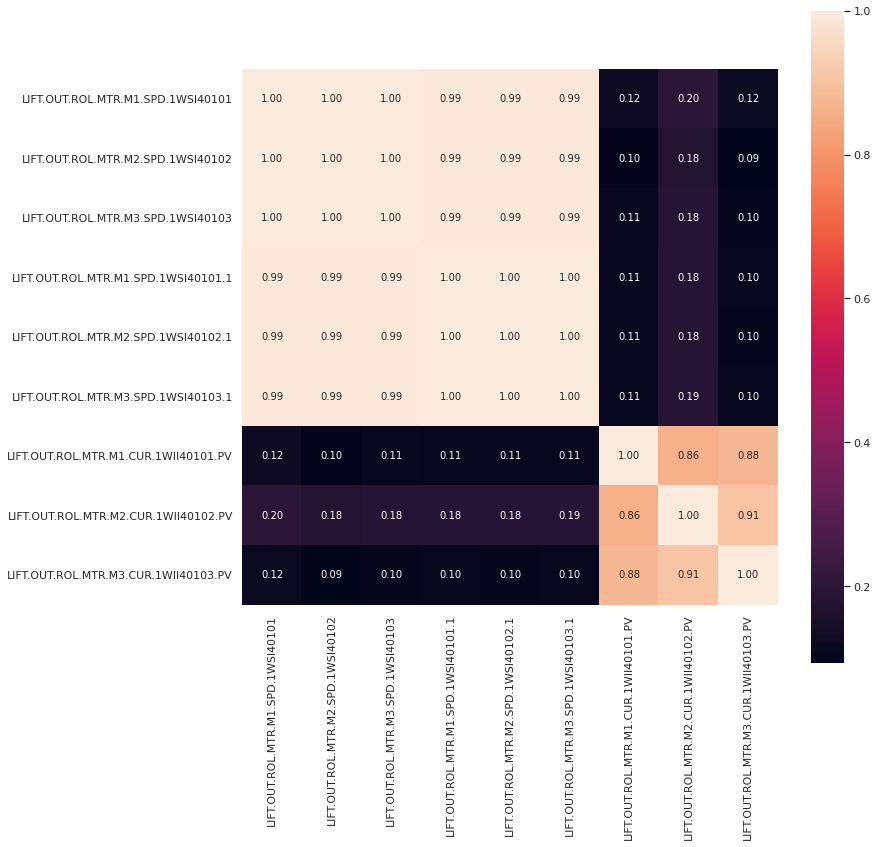

In [37]:
# 상관계수 데이터프레임을 배열로 저장
corr_arr = df.corr().to_numpy()
## 상관계수는 -1.0~1.0 까지 범위로 나옴.
## 절대값을 취해 0~1.0 범위에서 상관관계가 강한 경우 점수가 높게 나오도록 함 
corr_arr = abs(corr_arr)

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
sns.set(font_scale=1.0)
sns.heatmap(corr_arr, cbar=True, square=True, fmt='.2f', annot=True,
           annot_kws={'size':10}, yticklabels=col_atm, xticklabels=col_atm)
plt.show()

#### Left, Right 생산라인별 독립변수들의 상관계수 확인
* heatmap 색상옵션 참고 링크
    * https://matplotlib.org/stable/tutorials/colors/colormaps.html

In [40]:
# Left 생산라인별 컬럼간 상관계수 확인

# 컬럼집단 고르기
dict_l_r.keys()

# 'Left' 컬럼집단의 컬럼명 리스트
col_key = dict_l_r['Left']
col_key

# 데이터에서 해당 컬럼만 추출하여 저장하기
df = df_origin[col_key]
#df

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53804 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51077 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54224 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51652 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44277 missing from current font.
  font.set_

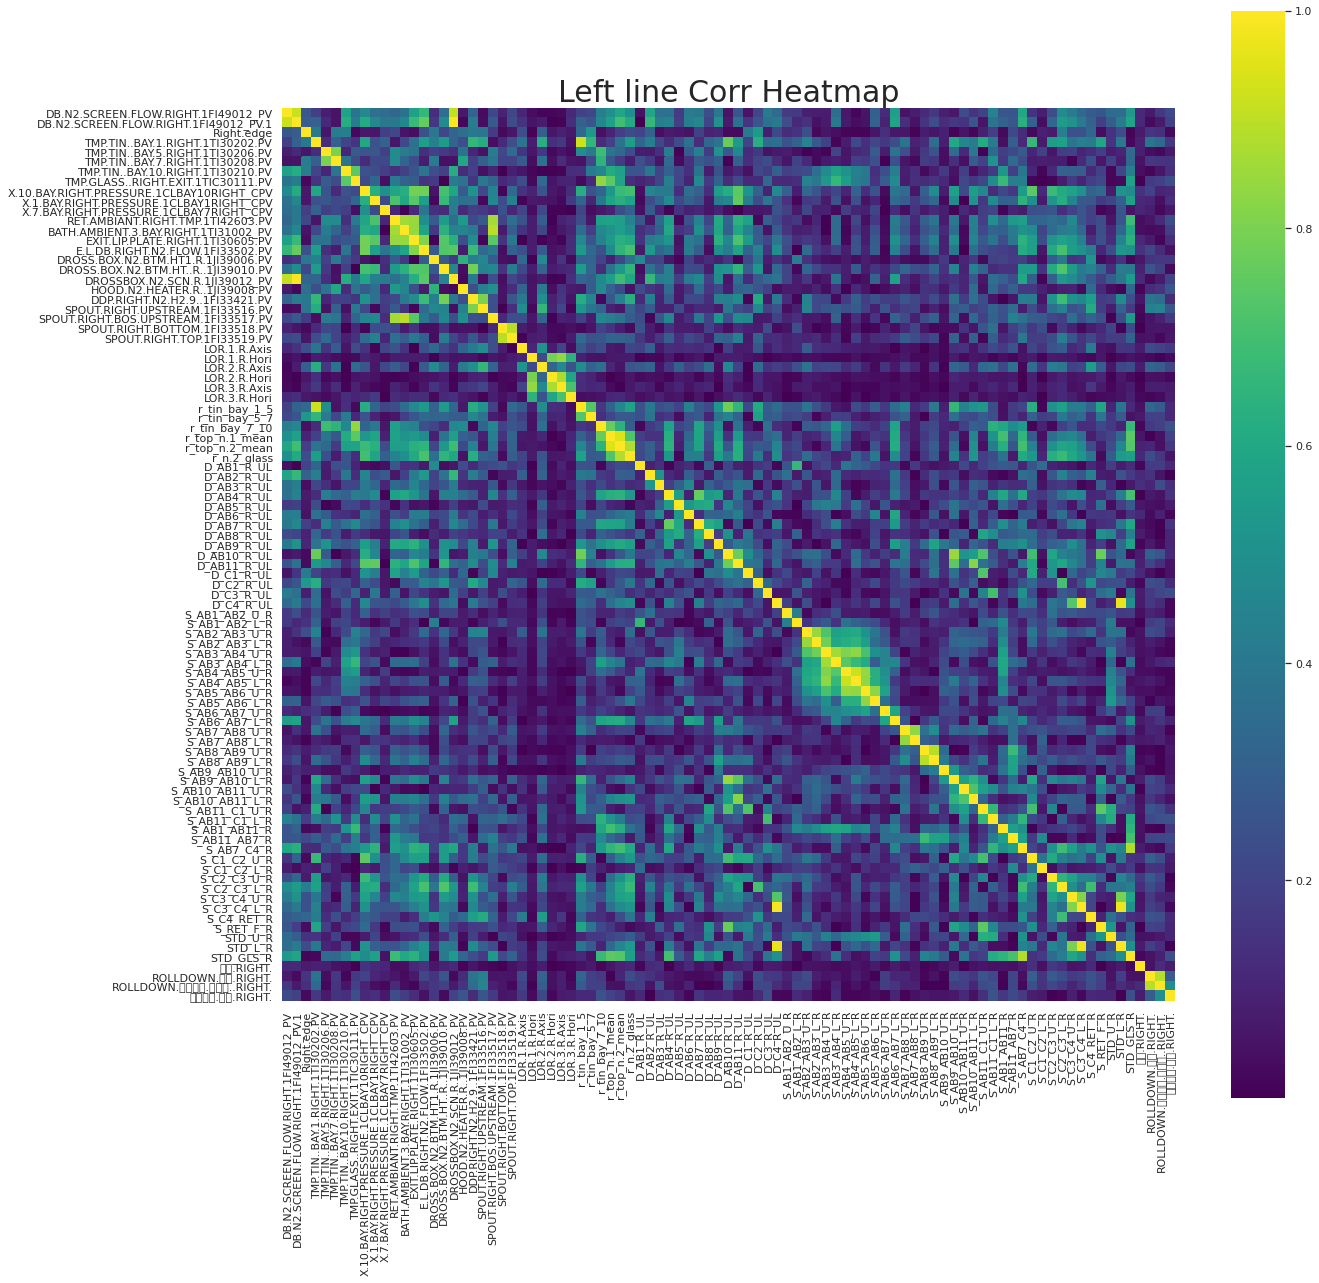

In [53]:
# 상관계수의 절대값 데이터프레임을 배열로 저장
corr_arr = df.corr().to_numpy()
corr_arr = abs(corr_arr)

# 시각화
#import seaborn as sns
#import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
sns.set(font_scale=1.0)
sns.heatmap(corr_arr, cmap='viridis', cbar=True, square=True, fmt='.2f', #annot=True, annot_kws={'size':10}, 
            yticklabels=col_key, xticklabels=col_key)
plt.title("Left line Corr Heatmap", fontsize=30)
plt.show()

In [47]:
# Right 생산라인별 컬럼간 상관계수 확인

# 'Right' 컬럼집단의 컬럼명 리스트
col_key = dict_l_r['Right']
col_key

# 데이터에서 해당 컬럼만 추출하여 저장하기
df = df_origin[col_key]
#df

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53804 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51077 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54224 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51652 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44277 missing from current font.
  font.set_

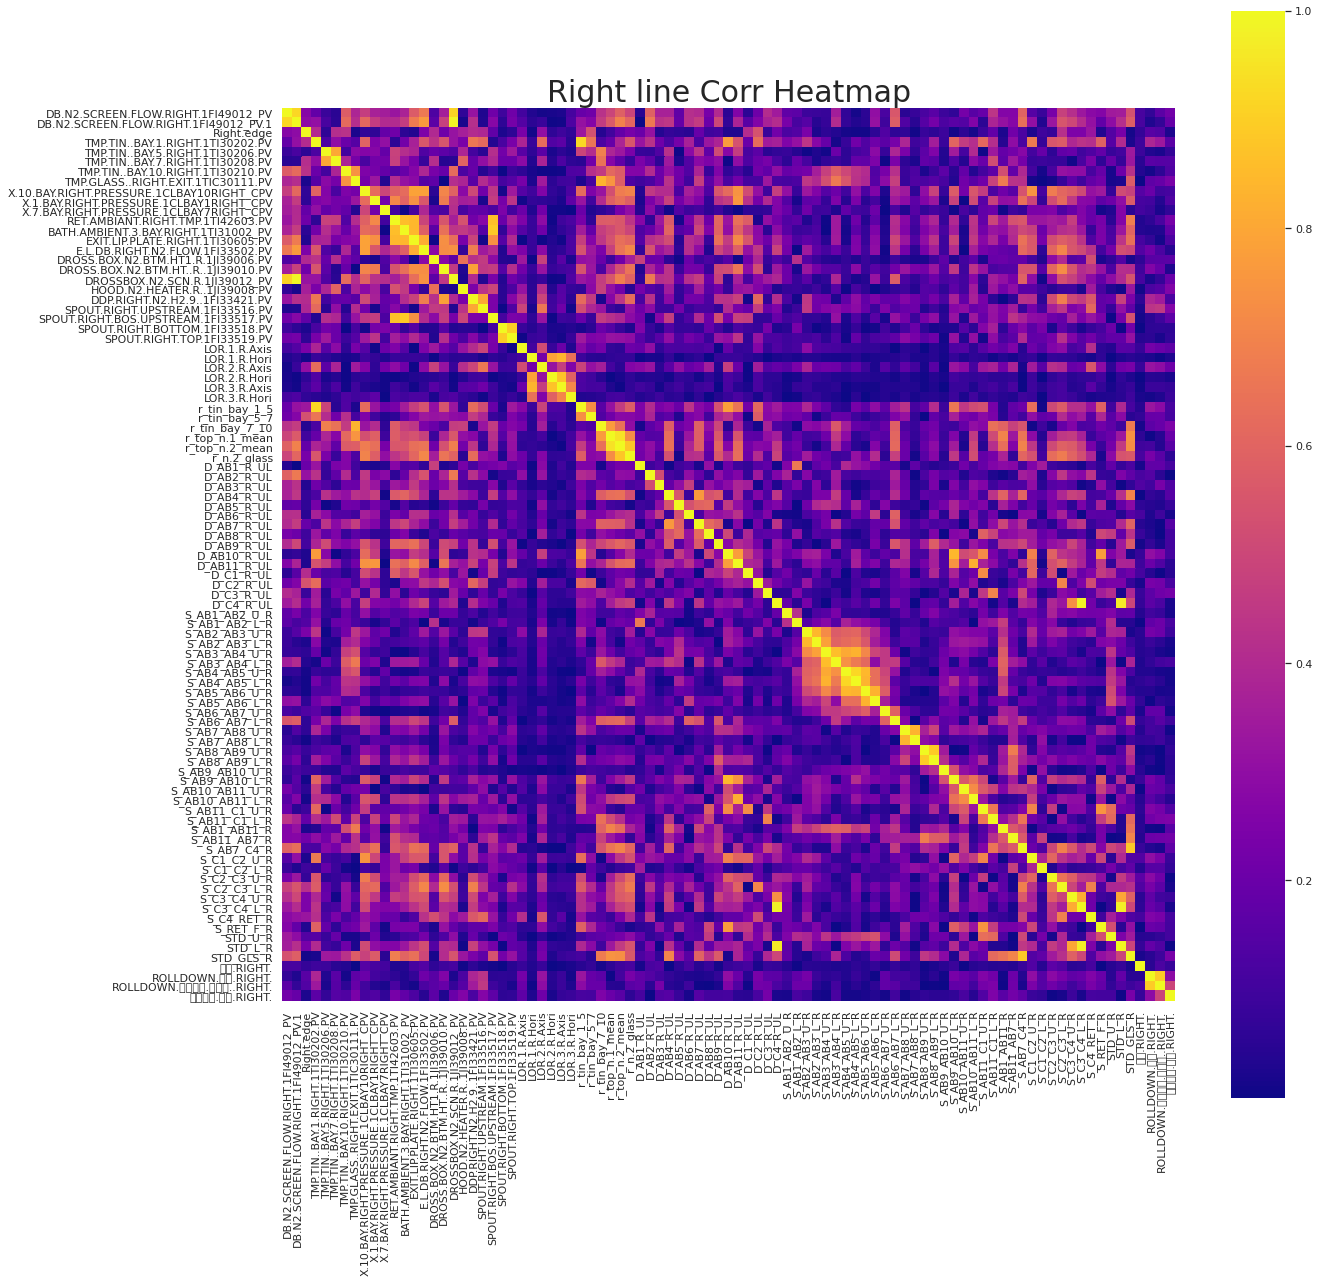

In [52]:
# 상관계수의 절대값 데이터프레임을 배열로 저장
corr_arr = df.corr().to_numpy()
corr_arr = abs(corr_arr)

# 시각화
#import seaborn as sns
#import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
sns.set(font_scale=1.0)
sns.heatmap(corr_arr, cmap='plasma', cbar=True, square=True, fmt='.2f', #annot=True, annot_kws={'size':10}, 
            yticklabels=col_key, xticklabels=col_key)
plt.title("Right line Corr Heatmap", fontsize=30)
plt.show()

### 상관계수가 높은 컬럼 제거

In [61]:
# 모든 컬럼에 대해 상관계수를 구하고 상관계수가 0.9 이상인 컬럼 중 1개만 남기고 모두 제거

# 모든 컬럼에 대해 상관계수의 절대값 구하기
corr_arr = abs(df_origin.corr())

# 상관계수가 0.9 이상인 컬럼 중 1개만 남기고 모두 제거
import numpy as np

del_list = []
for i, col in enumerate(corr_arr.columns):
    for j in range(len(corr_arr.index)):
        if i == j:
            continue
        elif corr_arr.index[i] in del_list:           
            break
        # print(i, j, corr_arr.index[j], np.abs(corr_arr.iloc[j,i]))
        if np.abs(corr_arr.iloc[j,i]) >= 0.9:
            del_list.append(corr_arr.index[j])
            # print(corr_arr.index[j], '-->', corr_arr.index[i])
# 확인
len(del_list)

685

#### 위 코드의 이해

In [ ]:
import pandas as pd
import numpy as np
narr = np.zeros(100).reshape(10, 10)
#narr1 = np.ones(36).reshape(6, 6)

df= pd.DataFrame(narr)
df.iloc[0:5, 0:5] = 1.0
df

In [ ]:
del_list = []

for i, col in enumerate(df.columns):
    for j in range(len(df.index)):
        # i==j인 경우에 다음 j로 넘어감
        # del_list에 이미 있는 인덱스면 for문 멈춤
        # 즉 저 아래 if문은, i!=j이고 del_list에 인덱스가 없을 경우 실행됨
        if i == j:
            continue
        elif df.index[i] in del_list:           
            break
        if np.abs(df.iloc[j,i]) >= 0.9:
            print(i)
            # del_list에 j번째 인덱스만 저장됨
            del_list.append(df.index[j])
# 결과적으로 상관계수 0.9이상인 컬럼 중 가장 먼저 등장한 i번째 컬럼만 남기고 나머지는 del_list에 추가됨
del_list